In [1]:
import scipy
import utils.preprocess as preprocess
import numpy as np
import scipy.io as io
import matplotlib.pyplot as plt
import solvers.pdas as pdas
import solvers.ipm as ipm
from timeit import timeit
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [2]:
# Load Data
stim = scipy.io.loadmat("./data/sampleMovie.mat")['stimulationSignal'][1:-50].squeeze()
data = io.loadmat("./data/post_demix.mat")
N, T = data['C'].shape
signals = data['C']

In [3]:
signals, trends, stim, disc_idx = preprocess.detrend(signals, stim, disc_idx=np.array([5]))

In [4]:
T = len(stim)
idx = np.random.randint(0, N)
signal = signals[idx,:]

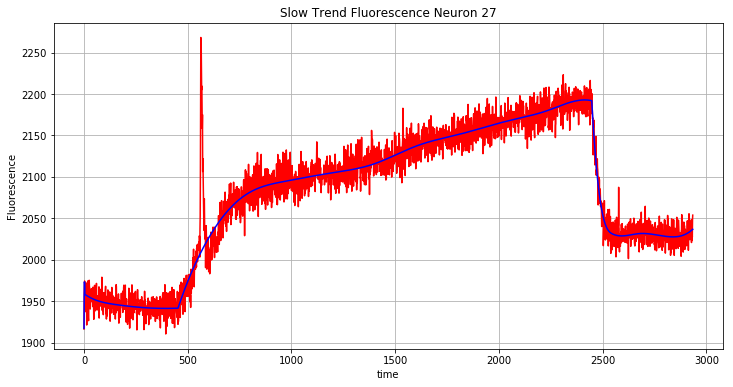

In [5]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(T), signal+trends[idx,:], 'r')
ax.plot(np.arange(T), trends[idx,:], 'b')

ax.set(xlabel='time', ylabel='Fluorescence',
       title='Slow Trend Fluorescence Neuron {}'.format(idx))
ax.grid()

plt.show()

In [6]:
import utils.noise
import numpy.random

In [549]:
idx = np.random.randint(0, N)
jdx = np.random.randint(0, N)
kdx = np.random.randint(0, N)
raw = np.flip(signals[idx,:], axis=0) + 2 * signals[jdx,:] + signals[kdx,:]
raw = np.append(raw, np.flip(raw, axis=0)*-1)
#raw = raw + 1000*np.cos(np.arange(len(raw))*.00051)

In [562]:
noise_factor = 1
raw_noise_std = utils.noise.estimate_noise([raw], summarize="mean")[0]
signal = np.sqrt(noise_factor**2 - 1) *raw_noise_std* np.random.randn(len(raw)) + raw
noise_std = utils.noise.estimate_noise([signal], summarize="mean")[0]
delta = (noise_std ** 2)

In [563]:
#r = .0000125
#x_hat, z_hat = ipm.solve(signal.copy(), r, True, 1e-4, 200, 1)
#lam = 3 * noise_std
#var_signal = np.mean(np.power(signal - np.median(signal),2))
var_signal = np.mean(np.power(signal,2))
scale =  noise_std**2 / np.sqrt(var_signal - delta)
#scale =  noise_std**2 / np.sqrt(np.var(signal) - delta)
lam = 3 * scale
x_hat, z_hat, iter_ = ipm.solve(signal.copy(), lam, False, 1e-4, 200, 1)

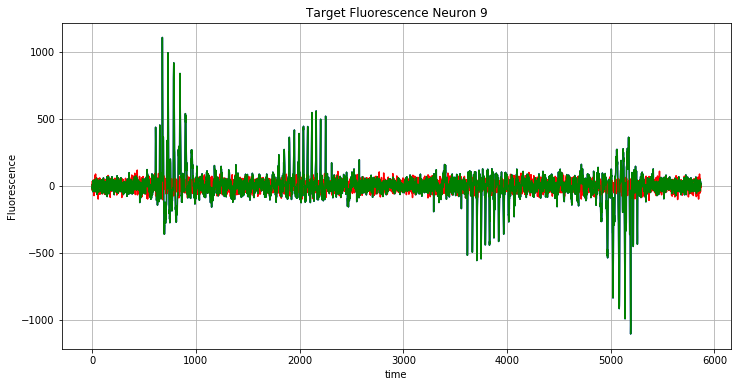

In [564]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(len(raw)), signal, 'b')
ax.plot(np.arange(len(raw)), numpy.random.randn(len(raw))*noise_std, 'r')
ax.plot(np.arange(len(raw)), raw, 'g')
#ax.plot(np.arange(T), noise_std * 3 * np.ones(len(signal)))
#ax.plot(np.arange(T), np.median(np.abs(x_hat - np.median(x_hat))) * 5 * np.ones(len(signal)))
#ax.plot(np.arange(T), -1*np.median(np.abs(x_hat - np.median(x_hat))) * 5 * np.ones(len(signal)))
ax.set(xlabel='time', ylabel='Fluorescence',
       title='Target Fluorescence Neuron {}'.format(idx))
ax.grid()

plt.show()

In [565]:
target = signal.copy()
lams_full = np.logspace(np.log(.01),np.log(1000),5000, base=np.e) * scale
grid_full = np.log(1 + (lams_full))
mses_full = np.zeros(len(lams_full))
x_hat, z_hat, iter_ = ipm.solve(target, lams_full[0], False, 1e-4, 200, 1)
mses_full[0] = np.mean(np.power(signal - x_hat, 2))
for ldx, lam in enumerate(lams_full[1:]):
    x_hat, z_hat, iter_ = pdas.warm_start(target, lam, z_hat, 1000, 1)
    mses_full[ldx + 1] = np.mean(np.power(signal - x_hat, 2))

In [566]:
lams = np.logspace(np.log(3),np.log(20), 5000, base=np.e) * scale
grid = np.log(1 + lams)
mses = np.zeros(len(lams_full))
x_hat, z_hat, iter_ = ipm.solve(target, lams[0], False, 1e-4, 200, 1)
mses[0] = np.mean(np.power(signal - x_hat, 2))
for ldx, lam in enumerate(lams[1:]):
    x_hat, z_hat, iter_ = pdas.warm_start(target, lam, z_hat, 1000, 1)
    mses[ldx + 1] = np.mean(np.power(signal - x_hat, 2))

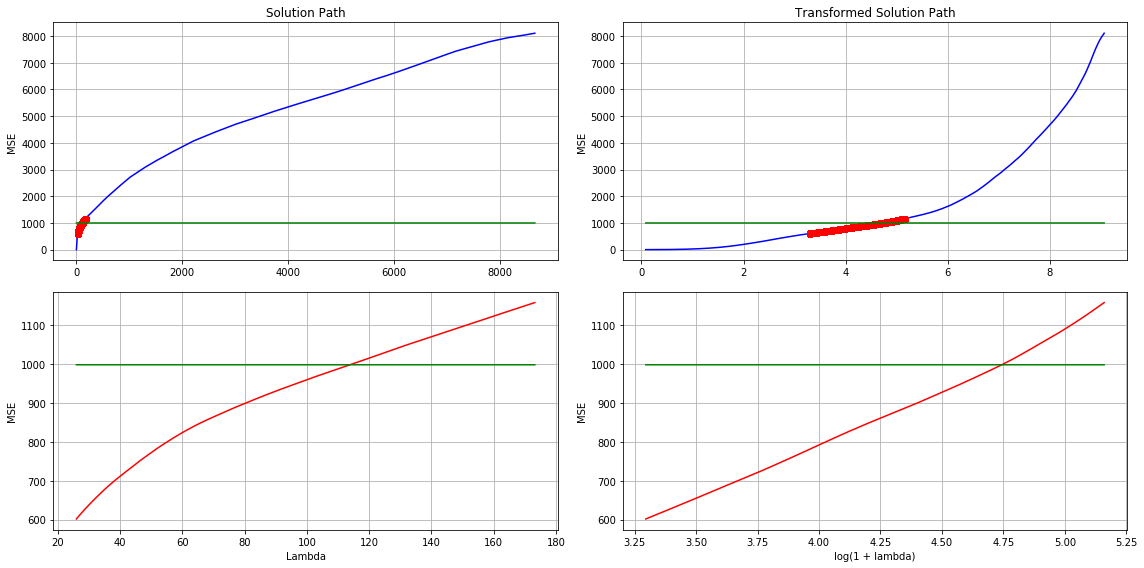

In [567]:
fig, axs = plt.subplots(2,2,figsize=(16, 8))

ax = axs[0,0]
ax.plot(lams_full, mses_full, 'b')
ax.plot(lams, mses, 'r', marker='o')
ax.plot(lams_full, np.ones(len(lams_full))*delta, 'g')
ax.set(ylabel='MSE', title='Solution Path')
ax.grid()

ax = axs[0,1]
ax.plot(grid_full, mses_full, 'b')
ax.plot(grid, mses, 'r', marker='o')
ax.plot(grid_full, np.ones(len(lams_full))*delta, 'g')
ax.set(ylabel='MSE', title="Transformed Solution Path")
ax.grid()

ax = axs[1,0]
ax.plot(lams, mses, 'r')
ax.plot(lams, np.ones(len(lams))*delta, 'g')
ax.set(xlabel='Lambda', ylabel='MSE')
ax.grid()

ax = axs[1,1]
ax.plot(grid, mses, 'r')
ax.plot(grid, np.ones(len(lams))*delta, 'g')
ax.set(xlabel='log(1 + lambda)', ylabel='MSE')
ax.grid()

plt.tight_layout()
plt.show()

# Search Algos

In [568]:
def solve_constrained_c(y, step_heuristic=60, maxiter=2000, verbose=0, tol=1e-3):
    
    # Init plotting vars
    lams = []
    mses = []
    iters = []
    tols = []
    
    # estimate noise levels and scale
    noise_std = utils.noise.estimate_noise([y], summarize="mean")[0]
    delta = noise_std ** 2  # constraint to satisfy
    scale = delta / np.sqrt(np.mean(np.power(y, 2) - delta)) # assuming centered
    
    # Compute first search point and step size
    int_min = np.log(3*scale + 1)
    int_width = np.log(20+(1/scale)) - np.log(3+(1/scale))
    lam = np.exp(int_width / 2 + int_min) - 1
    lams.append(lam)
    tau_int =  int_width / step_heuristic
    
    # Compute initial solution
    x_hat, z_hat, first_iters = pdas.solve(y, lam, maxiter, verbose)
    extra_iters = 0
    iters.append(extra_iters + first_iters)
    mse = np.mean(np.power(y - x_hat,2))
    mses.append(mse)
    tols.append(np.abs(delta - mse)/delta)
    direction = np.sign(delta - mse)
    
    if direction != 0 and tols[-1] > tol:
        # Take step to compute slope in transformed space
        lam = np.exp(np.log(lam + 1) + direction * tau_int) - 1
        lams.append(lam)
        x_hat, z_hat, iter_ = pdas.warm_start(y, lam, z_hat, maxiter, verbose)
        mse_prev = mse
        mse = np.mean(np.power(y - x_hat,2))
        mses.append(mse)
        tols.append(np.abs(delta - mse)/delta)
        extra_iters += iter_
        iters.append(extra_iters + first_iters)
        
        # Interpolate in transformed space
        slope = direction * (mse - mse_prev) / tau_int
        tau_interp = (delta - mse) / slope
        lam = np.exp(np.log(lam + 1) + tau_interp) - 1
        lams.append(lam)
        x_hat, z_hat, iter_ = pdas.warm_start(y, lam, z_hat, maxiter, verbose)
        mse = np.mean(np.power(y - x_hat,2))
        mses.append(mse)
        tols.append(np.abs(delta - mse)/delta)
        extra_iters += iter_
        iters.append(extra_iters + first_iters)
        direction = np.sign(delta - mse)

   # Compare iterating until we step across delta
    while (direction * np.sign(delta - mse) > 0 and tols[-1] > tol):
        lam = np.exp(np.log(lam + 1) + direction * tau_int) - 1
        lams.append(lam)
        x_hat, z_hat, iter_ = pdas.warm_start(y, lam, z_hat, maxiter, verbose)
        mse_prev = mse
        mse = np.mean(np.power(y - x_hat,2))
        mses.append(mse)
        tols.append(np.abs(delta - mse)/delta)
        extra_iters += iter_
        iters.append(extra_iters + first_iters)

    
    if direction != 0 and tols[-1] > tol:
        # Interpolate for final fit
        slope = direction * (mse - mse_prev) / tau_int
        tau_interp = (delta - mse) / slope
        lam = np.exp(np.log(lam + 1) + tau_interp) - 1
        lams.append(lam)
        x_hat, z_hat, iter_ = pdas.warm_start(y, lam, z_hat, maxiter, verbose)
        mse = np.mean(np.power(y - x_hat,2))
        mses.append(mse)
        tols.append(np.abs(delta - mse)/delta)
        extra_iters += iter_
        iters.append(extra_iters + first_iters)
    
    # return final computed solution
    return x_hat, z_hat, lams, mses, iters, tols, delta

In [569]:
x_hat, z_hat, search_lams, search_mses, iters, tols, delta = solve_constrained_c(signal, step_heuristic=75)

# Create Movies

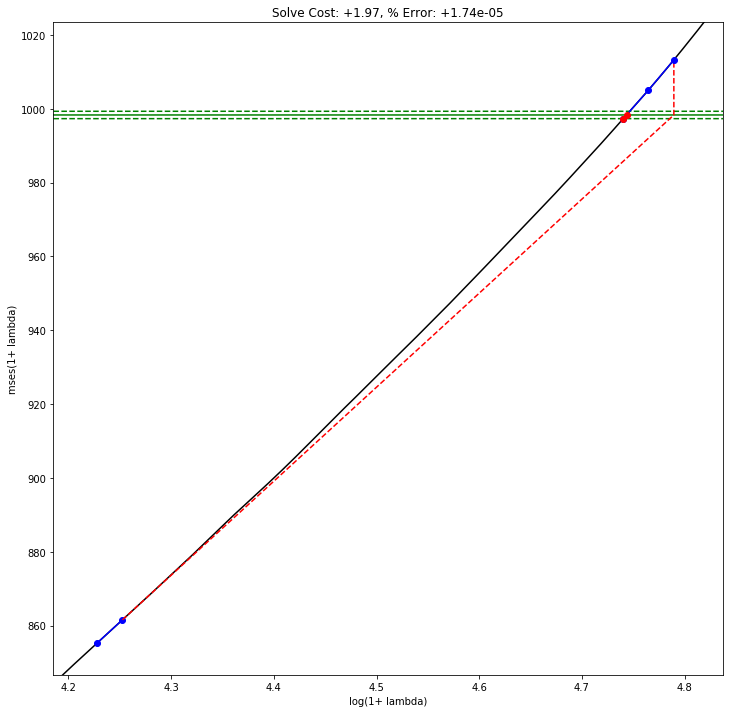

In [570]:
def update_plot(num, data, line1, line2, line3, line4):
    if num < 3:
        line1.set_data(data[..., :num])
        if num > 0:
            plt.title('Solve Cost: {:+.2f}, % Error: {:+.2e}'.format(iters[num-1] / iters[0], tols[num-1]))
        else:
            plt.title('Solve Cost: 0')
    elif num == 3:
        line2.set_data(np.array([[data[0,1], data[0,2], data[0,2]],[data[1,1], delta, data[1,2]]]))
        line3.set_data(data[..., 2:num])
        plt.title('Solve Cost: {:+.2f}, % Error: {:+.2e}'.format(iters[num-1] / iters[0], tols[num-1]))
    elif num < len(search_mses):
        line3.set_data(data[..., 2:num])
        plt.title('Solve Cost: {:+.2f}, % Error: {:+.2e}'.format(iters[num-1] / iters[0], tols[num-1]))
    else:
        line4.set_data(np.array([[data[0,-2], data[0,-1], data[0,-1]],[data[1,-2], delta, data[1,-1]]]))
        line4.set_data(data[..., len(search_mses)-2:num])
        plt.title('Solve Cost: {:+.2f}, % Error: {:+.2e}'.format(iters[num-1] / iters[0], tols[num-1]))
    return line1, line2, line3

# Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer(fps=1, metadata=dict(artist='Me'), bitrate=1800)

fig1 = plt.figure(figsize=(12,12))

data = np.array([np.log(1 + np.array(search_lams)), search_mses])
plt.plot(grid, mses, 'k')
plt.plot(grid, np.ones(len(lams))*delta, 'g')
plt.plot(grid, (1+1e-3)*np.ones(len(lams))*delta, 'g--')
plt.plot(grid, (1-1e-3)*np.ones(len(lams))*delta, 'g--')
l1, = plt.plot([], [], 'b-', marker='o')
l2, = plt.plot([], [], 'r--')
l3, = plt.plot([], [], 'b-', marker='o')
l4, = plt.plot([], [], 'r--', marker='o')
plt.xlabel('log(1+ lambda)')
plt.ylabel('mses(1+ lambda)')
plt.xlim(.99*np.min(np.log(1 + np.array(search_lams))),
         1.01*np.max(np.log(1 + np.array(search_lams))))
plt.ylim(.99*np.min(search_mses),
         1.01*np.max(search_mses))
line_ani = animation.FuncAnimation(fig1, update_plot, len(search_mses)+1, fargs=(data, l1, l2, l3, l4),
                                   interval=50, blit=True)
line_ani.save('search_algo_c.mp4', writer=writer)

In [571]:
def solve_constrained_a(y, step_heuristic=60, maxiter=2000, verbose=0, tol=1e-3):
    
    # Init plotting vars
    lams = []
    mses = []
    iters = []
    tols = []
    
    # estimate noise levels and scale
    noise_std = utils.noise.estimate_noise([y], summarize="mean")[0]
    delta = noise_std ** 2  # constraint to satisfy
    scale = delta / np.sqrt(np.mean(np.power(y, 2) - delta)) # assuming centered
    
    # Compute first search point and step size
    int_min = np.log(3*scale + 1)
    int_width = np.log(20+(1/scale)) - np.log(3+(1/scale))
    lam = np.exp(int_width / 2 + int_min) - 1
    lams.append(lam)
    tau_int =  int_width / step_heuristic
    
    # Compute initial solution
    x_hat, z_hat, first_iters = pdas.solve(y, lam, maxiter, verbose)
    extra_iters = 0
    iters.append(extra_iters + first_iters)
    mse = np.mean(np.power(y - x_hat,2))
    mses.append(mse)
    tols.append(np.abs(delta - mse)/delta)
    direction = np.sign(delta - mse)

   # Compare iterating until we step across delta
    while (direction * np.sign(delta - mse) > 0 and tols[-1] > tol):
        lam = np.exp(np.log(lam + 1) + direction * tau_int) - 1
        lams.append(lam)
        x_hat, z_hat, iter_ = pdas.warm_start(y, lam, z_hat, maxiter, verbose)
        mse_prev = mse
        mse = np.mean(np.power(y - x_hat,2))
        mses.append(mse)
        tols.append(np.abs(delta - mse)/delta)
        extra_iters += iter_
        iters.append(extra_iters + first_iters)

    
    if direction != 0 and tols[-1] > tol:
        # Interpolate for final fit
        slope = direction * (mse - mse_prev) / tau_int
        tau_interp = (delta - mse) / slope
        lam = np.exp(np.log(lam + 1) + tau_interp) - 1
        lams.append(lam)
        x_hat, z_hat, iter_ = pdas.warm_start(y, lam, z_hat, maxiter, verbose)
        mse = np.mean(np.power(y - x_hat,2))
        mses.append(mse)
        tols.append(np.abs(delta - mse)/delta)
        extra_iters += iter_
        iters.append(extra_iters + first_iters)
    
    # return final computed solution
    return x_hat, z_hat, lams, mses, iters, tols, delta

In [572]:
x_hat, z_hat, search_lams, search_mses, iters, tols, delta = solve_constrained_a(signal, step_heuristic=75)

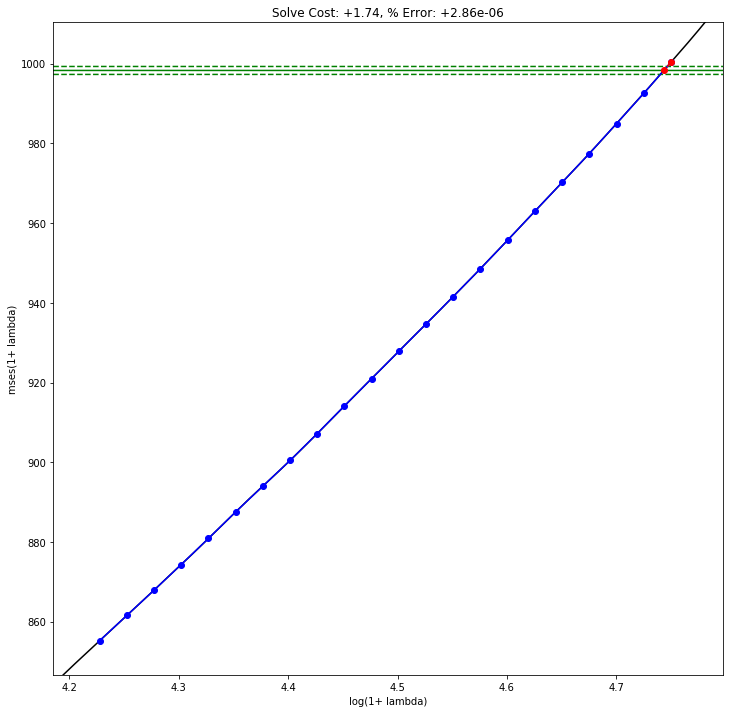

In [573]:
def update_plot(num, data, line1, line2):
    if num < len(search_mses) or len(search_mses) == 1:
        line1.set_data(data[..., :num])
        if num > 0:
            plt.title('Solve Cost: {:+.2f}, % Error: {:+.2e}'.format(iters[num-1] / iters[0], tols[num-1]))
        else:
            plt.title('Solve Cost: 0')
    else:
        line2.set_data(np.array([[data[0,-2], data[0,-1], data[0,-1]],[data[1,-2], delta, data[1,-1]]]))
        line2.set_data(data[..., len(search_mses)-2:num])
        plt.title('Solve Cost: {:+.2f}, % Error: {:+.2e}'.format(iters[num-1] / iters[0], tols[num-1]))
    return line1, line2

# Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer(fps=1, metadata=dict(artist='Me'), bitrate=1800)

fig1 = plt.figure(figsize=(12,12))

data = np.array([np.log(1 + np.array(search_lams)), search_mses])
plt.plot(grid, mses, 'k')
plt.plot(grid, np.ones(len(lams))*delta, 'g')
plt.plot(grid, (1+1e-3)*np.ones(len(lams))*delta, 'g--')
plt.plot(grid, (1-1e-3)*np.ones(len(lams))*delta, 'g--')
l1, = plt.plot([], [], 'b-', marker='o')
l2, = plt.plot([], [], 'r--', marker='o')
plt.xlabel('log(1+ lambda)')
plt.ylabel('mses(1+ lambda)')
plt.xlim(.99*np.min(np.log(1 + np.array(search_lams))),
         1.01*np.max(np.log(1 + np.array(search_lams))))
plt.ylim(.99*np.min(search_mses),
         1.01*np.max(search_mses))
line_ani = animation.FuncAnimation(fig1, update_plot, len(search_mses)+1, fargs=(data, l1, l2),
                                   interval=50, blit=True)
line_ani.save('search_algo_a.mp4', writer=writer)

# Aggregate Results Over All Signals And Noise Levels 

In [353]:
search_points = np.arange(10,150,2)
noise_factors = np.arange(1,8)
n_sols_c=np.zeros([len(signals), len(noise_factors), len(search_points)])
first_iters_c=np.zeros([len(signals), len(noise_factors), len(search_points)])
extra_iters_c=np.zeros([len(signals), len(noise_factors), len(search_points)])
tols_c=np.zeros([len(signals), len(noise_factors), len(search_points)])
ftols_c=np.zeros([len(signals), len(noise_factors), len(search_points)])
for sdx, raw in enumerate(signals):
    for ndx, noise_factor in enumerate(noise_factors):
        raw_noise_std = utils.noise.estimate_noise([raw], summarize="mean")[0]
        signal = np.sqrt(noise_factor**2 - 1) *raw_noise_std* np.random.randn(len(signal)) + raw
        for pdx, num_points in enumerate(search_points):
            _, _, lams, _, iters, tols, _ = solve_constrained_c(signal, step_heuristic=num_points)
            first_iters_c[sdx, ndx, pdx] = iters[0]
            n_sols_c[sdx, ndx, pdx] = len(lams)
            extra_iters_c[sdx, ndx, pdx]= iters[-1]
            tols_c[sdx, ndx, pdx] = tols[-1]
            ftols_c[sdx, ndx, pdx] = tols[0]

In [354]:
search_points = np.arange(10,150,2)
noise_factors = np.arange(1,8)
n_sols_a=np.zeros([len(signals), len(noise_factors), len(search_points)])
first_iters_a=np.zeros([len(signals), len(noise_factors), len(search_points)])
extra_iters_a=np.zeros([len(signals), len(noise_factors), len(search_points)])
tols_a=np.zeros([len(signals), len(noise_factors), len(search_points)])
ftols_a=np.zeros([len(signals), len(noise_factors), len(search_points)])
for sdx, raw in enumerate(signals):
    for ndx, noise_factor in enumerate(noise_factors):
        raw_noise_std = utils.noise.estimate_noise([raw], summarize="mean")[0]
        signal = np.sqrt(noise_factor**2 - 1) *raw_noise_std* np.random.randn(len(signal)) + raw
        for pdx, num_points in enumerate(search_points):
            _, _, lams, _, iters, tols, _ = solve_constrained_a(signal, step_heuristic=num_points)
            first_iters_a[sdx, ndx, pdx] = iters[0]
            n_sols_a[sdx, ndx, pdx] = len(lams)
            extra_iters_a[sdx, ndx, pdx]= iters[-1]
            tols_a[sdx, ndx, pdx] = tols[-1]
            ftols_a[sdx, ndx, pdx] = tols[0]

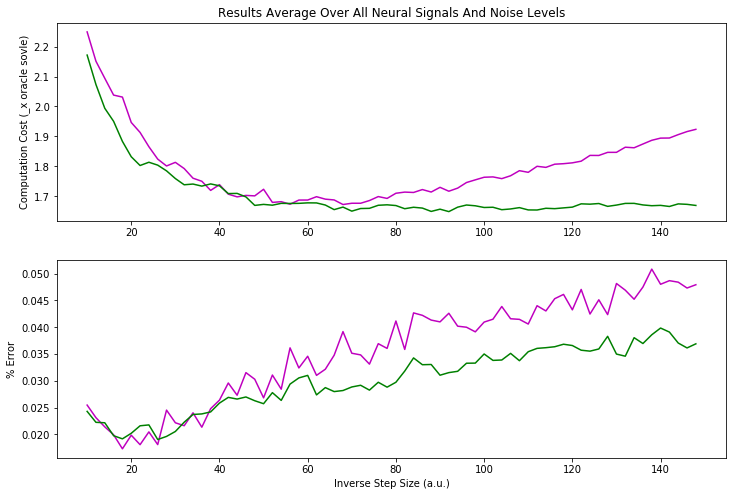

In [458]:
fig, ax = plt.subplots(2,1,figsize=(12, 8))
#for ndx, noise_factor in enumerate(noise_factors):
    #for sdx, signal in enumerate(signals):
        #ax[ndx].plot(search_points, ftols_c[sdx,ndx, :]*100)
        #ax[ndx].plot(search_points, tols_c[sdx,ndx, :]*100)
ax[0].plot(search_points, np.mean(np.mean(extra_iters_a/first_iters_a, axis=0), axis=0), 'm')
#ax[0].plot(search_points, np.mean(np.mean(extra_iters_b/first_iters_b, axis=0), axis=0), 'b')
ax[0].set(ylabel='Computation Cost (_x oracle sovle)', title='Results Average Over All Neural Signals And Noise Levels')
ax[0].plot(search_points, np.mean(np.mean(extra_iters_c/first_iters_c, axis=0), axis=0), 'g')
ax[1].plot(search_points, np.mean(np.mean(tols_a*100, axis=0), axis=0), 'm')
#ax[1].plot(search_points, np.mean(np.mean(tols_b, axis=0), axis=0), 'b')
ax[1].plot(search_points, np.mean(np.mean(tols_c*100, axis=0), axis=0), 'g')
        #ax[sdx].plot(search_points, n_sols_c[sdx, ndx, :])
        #ax[sdx].plot(search_points, extra_iters_c[sdx, ndx, :])
ax[1].set(xlabel='Inverse Step Size (a.u.)', ylabel='% Error')
#ax.grid()
plt.show()